In [1]:
# Mount drive code
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Setup the environment
!sudo apt install tesseract-ocr

!pip install torch
!pip3 install torchvision
!pip install pytesseract
!pip install python-Levenshtein
!pip install munkres

%env MODEL_PATH=/content/drive/My Drive/CSC420 Final Project/crnn.pytorch-master

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (30.2 MB/s)
debconf: unable to initia

In [0]:
# Python globals
base_dir = '/content/drive/My Drive/CSC420 Final Project'
model_dir = base_dir + '/crnn.pytorch-master'

# Using Tesseract for Python

% Daily Value*

 

~ VTotal Fat 1.59

 

2%
ae
saturated Fat Og 0%

 

 

Trans Fat 0g Open a bag of |

Cholesterol Omg 0% | and you’re in fc

ture” sodium 10mg 0% | blueberries, goj
ature Total Carbohydrates 22g 7% — _ noth
a eautiful pepita

jj i) It's the Made In

   

How do we do it
to grow the best
are gently pickec
to balance their I


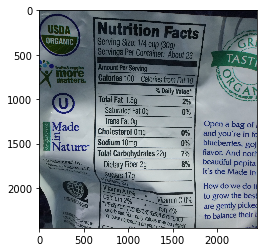

In [6]:
import matplotlib.pyplot as plt
import pytesseract
import cv2
from PIL import Image

output_file = model_dir + '/nutrient_data.txt'
image_path = base_dir + '/input_dataset/1.jpg'
img = cv2.imread(image_path)

output_string = pytesseract.image_to_string(Image.open(image_path))
f = open(output_file, 'w+')
f.write(output_string)
f.close()

plt.imshow(img)
print(output_string)

In [0]:
!cat "${MODEL_PATH}/nutrient_data.txt"

Metadata

Filename 201612v1-docdollars-product_payments
Format csv
Url https://projects.propublica.org/docdollars/
Domain healthcare
Keywords Physicians, drugs, medicine, pharmaceutical, transactions
Type tabular
Rows 500
Columns 18
Missing 5.2%
License cc

Released JAN 2017

In [10]:
import re
from Levenshtein import distance
import numpy as np
from munkres import Munkres
import cv2
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt


pairs = []

_digits = re.compile('\d')
_alpha = re.compile('[a-zA-Z]')


def contains_digits(s):
    return bool(_digits.search(s))


def contains_alpha(s):
    return bool(_alpha.search(s))

# Create a pair of (possible keyword, values)
# The label follows a predictable structure of nutrient name : nutrient amount, which we can take 
# advantage of. We get rid of obvious bad lines
def make_pairs(ocr_output, line_char_threshold=5):
    pairs = []

    # Clean up the lines first a little bit
    lines = filter(lambda line : not line == ' ', filter(None, ocr_output.split('\n')))
    for i, line in enumerate(lines):
        if not (len(line) < line_char_threshold or (not bool(re.compile('\d').search(line))) or (not bool(re.compile('[a-zA-Z]').search(line)))):
            continue

        num_letters = 0
        for k in range(len(line)):
            if(bool(re.compile('[a-zA-Z]').search(line[k]))):
                num_letters += 1
            if(num_letters > 4 and line[k].isdigit()): #needs to be a valid nutrient info (alpha word bigger than 3)
                line = line[0:(k - 1)] + ' ' + line[k:(len(line) - 1)] #expecting extraneous info? (i.e. a | from the label?)
                # print(line)
                break

        words = line.strip().split(' ')
        key = words[0]
        words = words[1:]
        for j, word in enumerate(words):
            if not contains_digits(word): #might be part of the nutrient keyword name
                key += ' ' + word
            else:
                words = words[j:] #basically create the keyname by going thru the split thing, and then once you get to a thing with numbers, thats when you stop and create the pair
                break

        pairs.append((key, (' ').join(words), i)) #concatatenation of all the 'numbers' after the first thing that contains numbers

    return pairs


def match_bipartite(pairs, keywords):
    """
    Uses the Munkres bipartite matching algorithm to find the best
    matching between the OCR pairs and label keywords.
    Returns (keyword, OCR value, OCR line)
    """
    pairs = list(pairs)
    keywords = list(keywords)

    distances = np.zeros((len(keywords), len(pairs)), dtype=np.int32).tolist()
    for i, key in enumerate(keywords):
        for j, pair in enumerate(pairs):
            distances[i][j] = distance(pair[0], key)

#    keywords_ordered = Keywords.ordered
#    start_line = 3
#    for i, key in enumerate(keywords):
#        for j, pair in enumerate(pairs):
#            line = pair[2] - start_line
#            expected_line = keywords_ordered.index(key)
#            tol = (int(0.2 * expected_line) + 2)
#            diff = np.abs((expected_line - line)) - tol
#            diff = max(diff, 0)
#            diff = np.log(diff + 1)
#            print(diff, key, pair, expected_line)
#            distances[i][j] += diff

    m = Munkres()
    # Copy distance matrix to preserve distances
    indices = m.compute(distances.copy())

    key_pairs = []
    # (i, j), for optimal mapping from keywords[i] -> ocr_tuples[j].
    for i, j in indices:
        keyword = keywords[i]
        # Skip if half of the characters are wrong.
        if distances[i][j] <= len(keyword)/2:
            key_pairs.append((keyword, pairs[j][1], pairs[j][2]))

    return key_pairs


def check_keyword_ordering(keyword_pairs):
    # Sort keyword_tuples by line number
    # Compare against ordering
#    key_lines = len(Keywords.label.values())
#    try:
#        start_line = [kp[2] for kp in keyword_pairs
#                      if kp[0] is Keywords.label.calories][0]
#    except IndexError:
#        start_line = 0
#
#    thresh = start_line + key_lines
#    wrong_indices = []
#    for kp in keyword_pairs:
#        if kp[2] > thresh:
#            wrong_indices.append(kp[2])
#
#    return wrong_indices

    numLines = len(keyword_pairs)

    wrong_indices = []
    for kp in keyword_pairs:
        if kp[2] > numLines:
            wrong_indices.append(kp[2])

    return wrong_indices


def keyword_pairs(pairs):
    """
    Take a list of pairs and return a list of pairs,
    with first values having the appropriate keyword.
    (keyword, stuff)
    """
    i = 1
    newKeys = []
    for k in pairs:
        newKeys.append((k[0], k[1], i))
        i += 1
    #print(pairs)
    #print(newKeys)
    key_pairs = match_bipartite(newKeys, keywords)
    print(key_pairs)
    print('\n\n')
    remove_indices = check_keyword_ordering(key_pairs)
    for ri in remove_indices:
        for nk in newKeys:
            if nk[2] is ri:
                newKeys.remove(nk) #remove extraneous lines?

    if len(remove_indices) > 0:
        key_pairs = match_bipartite(newKeys, keywords)

    return key_pairs

def remove_bad_pairs(pairs):
    good_pairs = []

    for pair in pairs:
        bad = True
        for key in keywords:
            slide = (len(pair[0]) - len(key)) + 1
            if(slide < 1):
                slide = 1
            for i in range(slide):
                thresh = len(key) / 2
                temp = pair[0]
                #print(temp[i:(len(key) - 1 + i)])
                dist = distance(key, temp[i:(len(key) - 1 + i)])
                if dist <= thresh:
                    bad = False
                    break

        if not bad:
            good_pairs.append(pair)

    return good_pairs


def clean_values(tuples, index=1):
    """
    Cleans text values in the specified index of the tuple.
    Removes all non-number characters except for '.'
    """
    clean_tuples = []
    for t in tuples:
        t_new = list(t)
        val = t_new[index]
        if val is not None:
            val = re.sub('[^mg0-9.]', '', val)
            if len(val) > 0 and val[-1] == '9':
                val = val[:-1] + 'g'
            val = re.sub('[^0-9.]', '', val)

        t_new[index] = val
        clean_tuples.append(tuple(t_new))

    return clean_tuples


def post_process(raw_text, demo=False):
    """
    Consume OCR text, producing a Label object with
    the appropriate information.
    """
    print('Start post-processing step')
    all_pairs = make_pairs(raw_text)
    print(all_pairs)
    print('\n\n')
    if all_pairs is False:
        return False
    better_pairs = remove_bad_pairs(all_pairs)
    print(better_pairs)
    print('\n\n')
    #better_pairs = fix_garbage_sugar(good_pairs)
    #print(better_pairs)
    #print('\n\n')
    key_pairs = keyword_pairs(better_pairs)
    print(key_pairs)
    print('\n\n')
    #key_tuples = split_percentages(key_pairs)
    key_tuples = clean_values(key_pairs)
    # Don't use percentages or line numbers for now
    key_map = dict((a, b) for a, b, c, d in key_tuples)
    print(key_map)
    #return Label(keyword_map=key_map)

nutrients_path = base_dir + '/canadian_nutrients.txt'

# Create a set of known nutrient keywords we're searching for
keywords = {}
nutrients_file = open(nutrients_path, 'r+')
for line in nutrients_file:
  keywords[line.strip()] = ""

print('Keywords loaded:\n', keywords)

# Scan the images. Run an image through tesseract, and compare with the keywords
image_path = base_dir + '/input_dataset/File_001.png'
img = cv2.imread(image_path)

# Clean up bad lines calculated through

# Levenshtein distance
output_string = pytesseract.image_to_string(Image.open(image_path))
post_process(output_string)
plt.imshow(img)

Keywords loaded:
 {'calories': '', 'calories/calories': '', 'fat/lipides': '', 'saturated/satures': '', 'trans/trans': '', 'carbohydrate': '', 'cholesterol': '', 'cholesterol/cholesterol': '', 'sodium/sodium': '', 'carbohydrate/glucides': '', 'fibre/fibres': '', 'sugars/sucres': '', 'protein': ''}
Start post-processing step
[('Nutrition Facts', 'Facts', 0), ('Valeur nutritive', 'nutritive', 1), ('Amount', '', 3), ('Teneur', '', 4), ('cececteietiniectinlta an LAT', 'an LAT', 5), ('Cholesterol! / Cholestérol §', '/ Cholestérol §', 10), ('Fibre / Fibres ig', '/ Fibres ig', 13), ('mineC __', '__', 16), ('ee', '', 17), ('vitamin C / Vita', 'C / Vita', 18), ('Gaicium / Calc —', '/ Calc —', 19), ('ee Fy eae Dae', 'Fy eae Dae', 20), ('al >', '>', 21), ('', '', 22), ('', '', 23), ('', '', 24), ('% vale', 'vale', 25), ('————', '', 26), ('—_—', '', 27), ('——', '', 28)]



[('Cholesterol! / Cholestérol §', '/ Cholestérol §', 10), ('Fibre / Fibres ig', '/ Fibres ig', 13)]



[('cholesterol/choleste

ValueError: ignored

# Original Code

Keywords loaded:
 {'calories': '', 'calories/calories': '', 'fat/lipides': '', 'saturated/satures': '', 'trans/trans': '', 'carbohydrate': '', 'cholesterol': '', 'cholesterol/cholesterol': '', 'sodium/sodium': '', 'carbohydrate/glucides': '', 'fibre/fibres': '', 'fiber': '', 'dietary fiber': '', 'sugars/sucres': '', 'sugars': '', 'protein': '', 'total fat': '', 'total carbohydrate': ''}
[('ms Serving Size', '2 oz (56g- about 1/8 box', 0), ('et Servings Per Container about', 'Servings Per Container about', 1), ('Calories', '200 Calories from Fat 1', 2), ('L Total Fatig —', '2', 3), ('+ Saturated FatOg', '0', 4), ('Cholestero', '0mg .. 0', 5), ('Sodium Omg -', '0', 6), ('Total Carbohydrate', '42g 14', 7), ('Dietary Fiber', '2g 8', 8), ('Vitamin A', '0% «© Vitamin C 0', 9), ('Calclum', '0% ® [ron 10', 10), ('Thiamin', '35% e Riboflavin 15', 11), ('Niacin', '15% © Folate 30', 12), ('* Percent Dally Values are based on a', '2,00', 13), ('Calories:', '2,000 2,50', 14), ('Total Fat "Lees than

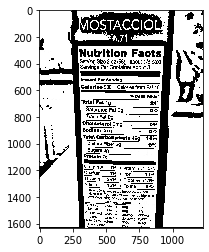

['cholesterol', 'dietary fiber', 'total carbohydrate']
[0.0, 25.0, 42.0]


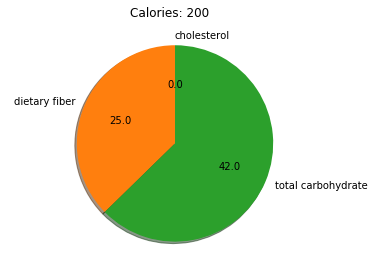

In [38]:
import re
from Levenshtein import distance
import numpy as np
from munkres import Munkres
import cv2
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt


pairs = []

_digits = re.compile('\d')
_alpha = re.compile('[a-zA-Z]')


def contains_digits(s):
    return bool(_digits.search(s))


def contains_alpha(s):
    return bool(_alpha.search(s))


def make_pairs(raw_text):
    """
    Consume raw OCR text, turning each line into a pair of string values.
    """
    lines = raw_text.split('\n')
    # Remove empty lines
    lines = filter(None, lines)
    lines = filter(lambda x: x != ' ', lines)
    pairs = []
    i = 0 #replace with the raw regex thing, move function out of for loop
    for line in lines:
        def check_line(line):
            return len(line) > 5\
                and contains_digits(line)\
                and contains_alpha(line)

        if not check_line(line):
            continue

        alpha = 0
        lastAlpha = False
        for k in range(len(line)):
            if(contains_alpha(line[k])):
                alpha += 1
                lastAlpha = True
            if(contains_digits(line[k]) and (alpha > 3)): #needs to be a valid nutrient info (alpha word bigger than 3)
                if(lastAlpha):
                    line = line[0:(k - 1)] + ' ' + line[k:(len(line) - 1)] #expecting extraneous info? (i.e. a | from the label?)
                break

        words = line.strip().split(' ')
        key = words[0]
        words = words[1:]
        for j, word in enumerate(words):
            if not contains_digits(word): #might be part of the nutrient keyword name
                key += ' ' + word
            else:
                words = words[j:] #basically create the keyname by going thru the split thing, and then once you get to a thing with numbers, thats when you stop and create the pair
                break

        pairs.append((key, (' ').join(words), i)) #concatatenation of all the 'numbers' after the first thing that contains numbers
        i += 1

    return pairs


def match_bipartite(pairs, keywords):
    """
    Uses the Munkres bipartite matching algorithm to find the best
    matching between the OCR pairs and label keywords.
    Returns (keyword, OCR value, OCR line)
    """
    pairs = list(pairs)
    keywords = list(keywords)

    distances = np.zeros((len(keywords), len(pairs)), dtype=np.int32).tolist()
    for i, key in enumerate(keywords):
        for j, pair in enumerate(pairs):
            distances[i][j] = distance(pair[0], key)

#    keywords_ordered = Keywords.ordered
#    start_line = 3
#    for i, key in enumerate(keywords):
#        for j, pair in enumerate(pairs):
#            line = pair[2] - start_line
#            expected_line = keywords_ordered.index(key)
#            tol = (int(0.2 * expected_line) + 2)
#            diff = np.abs((expected_line - line)) - tol
#            diff = max(diff, 0)
#            diff = np.log(diff + 1)
#            print(diff, key, pair, expected_line)
#            distances[i][j] += diff

    m = Munkres()
    # Copy distance matrix to preserve distances
    indices = m.compute(distances.copy())

    key_pairs = []
    # (i, j), for optimal mapping from keywords[i] -> ocr_tuples[j].
    for i, j in indices:
        keyword = keywords[i]
        # Skip if half of the characters are wrong.
        if distances[i][j] <= len(keyword)/2:
            key_pairs.append((keyword, pairs[j][1], pairs[j][2]))

    return key_pairs


def check_keyword_ordering(keyword_pairs):
    # Sort keyword_tuples by line number
    # Compare against ordering
#    key_lines = len(Keywords.label.values())
#    try:
#        start_line = [kp[2] for kp in keyword_pairs
#                      if kp[0] is Keywords.label.calories][0]
#    except IndexError:
#        start_line = 0
#
#    thresh = start_line + key_lines
#    wrong_indices = []
#    for kp in keyword_pairs:
#        if kp[2] > thresh:
#            wrong_indices.append(kp[2])
#
#    return wrong_indices

    numLines = len(keyword_pairs)

    wrong_indices = []
    for kp in keyword_pairs:
        if kp[2] > numLines:
            wrong_indices.append(kp[2])

    return wrong_indices


def keyword_pairs(pairs):
    """
    Take a list of pairs and return a list of pairs,
    with first values having the appropriate keyword.
    (keyword, stuff)
    """
    i = 1
    newKeys = []
    for k in pairs:
        newKeys.append((k[0], k[1], i))
        i += 1
    #print(pairs)
    #print(newKeys)
    key_pairs = match_bipartite(newKeys, keywords)
    print(key_pairs)
    print('\n\n')
    remove_indices = check_keyword_ordering(key_pairs)
    for ri in remove_indices:
        for nk in newKeys:
            if nk[2] is ri:
                newKeys.remove(nk) #remove extraneous lines?

    if len(remove_indices) > 0:
        key_pairs = match_bipartite(newKeys, keywords)

    return key_pairs


def split_percentages(key_pairs):
    """
    Attempt to intelligently split pairs into 3-tuples.
    (keyword, stuff) -> (keyword, value, percent)
    """
    def calories_tuple(pair): #pair[2] is line #
        return (pair[0], pair[1].split(' ')[0], None, pair[2])

    def percent_tuple(pair):
        right = pair[1].split(' ')
        amount = right[0]
        pct = (' ').join(right[1:])
        return (pair[0], amount, pct, pair[2])

    tuples = []
    for key_pair in key_pairs:
        key, right, line = key_pair
        try:
            if key == 'calories':#Keywords.label.calories:
                tuples.append(calories_tuple(key_pair))
            else:
                tuples.append(percent_tuple(key_pair))
        except IndexError:
            tuples.append((key_pair[0], key_pair[1], None, key_pair[2]))

    return tuples


def remove_bad_pairs(pairs):
    good_pairs = []

    for pair in pairs:
        bad = True
        for key in keywords:
            slide = (len(pair[0]) - len(key)) + 1
            if(slide < 1):
                slide = 1
            for i in range(slide):
                thresh = len(key) / 2
                temp = pair[0]
                #print(temp[i:(len(key) - 1 + i)])
                dist = distance(key, temp[i:(len(key) - 1 + i)])
                if dist <= thresh:
                    bad = False
                    break

        if not bad:
            good_pairs.append(pair)

    return good_pairs


def clean_values(tuples, index=1):
    """
    Cleans text values in the specified index of the tuple.
    Removes all non-number characters except for '.'
    """
    clean_tuples = []
    for t in tuples:
        t_new = list(t)
        val = t_new[index]
        if val is not None:
            val = re.sub('[^mg0-9.]', '', val)
            if len(val) > 0 and val[-1] == '9':
                val = val[:-1] + 'g'
            val = re.sub('[^0-9.]', '', val)

        t_new[index] = val
        clean_tuples.append(tuple(t_new))

    return clean_tuples


def fix_garbage_sugar(pairs):
    betterPairs = []
    i = -1
    done = False

    for pair in pairs:
        slide = (len(pair[0]) - 6) + 1
        if(slide < 1):
            slide = 1
        for i in range(slide):
            temp = pair[0]
            #print(temp[i:(5 + i)])
            dist = distance(Keywords.label.sugars, temp[i:(5 + i)])
            if dist <= 2:
                i = pair[2]
                done = True
                break
        if(done):
            break

    for pair in pairs:
        name = pair[0]
        if(pair[2] == i):
            name = Keywords.label.sugars
        betterPairs.append((name, pair[1], pair[2]))

    return betterPairs


def post_process(raw_text, demo=False):
    """
    Consume OCR text, producing a Label object with
    the appropriate information.
    """
    all_pairs = make_pairs(raw_text)
    print(all_pairs)
    print('\n\n')
    if all_pairs is False:
        return False
    better_pairs = remove_bad_pairs(all_pairs)
    print(better_pairs)
    print('\n\n')
    #better_pairs = fix_garbage_sugar(good_pairs)
    #print(better_pairs)
    #print('\n\n')
    key_pairs = keyword_pairs(better_pairs)
    print(key_pairs)
    print('\n\n')
    key_tuples = split_percentages(key_pairs)
    key_tuples = clean_values(key_tuples)
    # Don't use percentages or line numbers for now
    key_map = dict((a, b) for a, b, c, d in key_tuples)
    print(key_map)

    return key_map
    #return Label(keyword_map=key_map)

nutrients_path = base_dir + '/na_nutrients.txt'

# Create a set of known nutrient keywords we're searching for
keywords = {}
nutrients_file = open(nutrients_path, 'r+')
for line in nutrients_file:
  keywords[line.strip()] = ""

print('Keywords loaded:\n', keywords)

# Scan the images. Run an image through tesseract, and compare with the keywords
image_path = base_dir + '/input_dataset/final_img.jpg'
img = cv2.imread(image_path)

# Clean up bad lines calculated through

# Levenshtein distance
output_string = pytesseract.image_to_string(Image.open(image_path))
results = post_process(output_string)
print(type(results))

calories = results['calories'] or results['calories/calories']
results.pop('calories/calories', None)
results.pop('calories', None)
#print('results:', results)
plt.imshow(img)
plt.show()

keys = list(results.keys())
values = [float(results[k]) for k in keys]

import numpy as np
def absolute_value(val):
    a  = np.round(val/100.*sum(values), 0)
    return a

fig1, ax1 = plt.subplots()
fig1.suptitle('Calories: ' + calories)
ax1.pie(values, labels=keys, autopct=absolute_value,
        shadow=True, startangle=90)
ax1.axis('equal')

fig1.savefig(base_dir + '/pie1.png')
print(keys)
print(values)


In [0]:
"""
Create key-pairs and get levenshstein distance between the things
• Use Optical Character Recognition (OCR)
• Filter through the Tesseract output and decide which information to
keep
• Make a key/value pairs data structure with the nutrient name and value
• Use bipartite graph matching algorithm to determine the Levenshtein
distance between each key to a known nutrient name and minimize total
edit distance among all matches
• Output information to a text file for making pie charts in the next step
"""
from Levenshtein import distance as levenshtein_distance

nutrients_path = base_dir + '/canadian_nutrients.txt'

# Create a set of known nutrient keywords we're searching for
keywords = {}
nutrients_file = open(nutrients_path, 'r+')
for line in nutrients_file:
  keywords[line.strip()] = ""

print('Keywords loaded:\n', keywords)

# Scan the images. Run an image through tesseract, and compare with the keywords
image_path = base_dir + '/input_dataset/File_002.png'
img = cv2.imread(image_path)

# Clean up bad lines calculated through


# Levenshtein distance
output_string = pytesseract.image_to_string(Image.open(image_path))
post_process(output_string.split('\n'))
"""
for i, line in enumerate(output_string.split('\n')):
  print(line.lower())

plt.imshow(img)
print('Tesseract output:\n', output_string)
"""

Keywords loaded:
 {'calories': '', 'fat/lipides': '', 'saturated': '', 'trans/trans': '', 'carbohydrate': '', 'cholestorol': '', 'sodium/sodium': '', 'carbohydrate/glucides': '', 'fibre/fibres': '', 'sugars/sucres': '', 'protein': ''}
{'calories': 'mL)', 'fat/lipides': 'g', 'saturated': 'b', 'trans/trans': '0g', 'carbohydrate': 'mL)', 'cholestorol': 'lot', 'sodium/sodium': 'iron.', 'carbohydrate/glucides': 'De', 'fibre/fibres': 'fer.', 'sugars/sucres': 'ca!', 'protein': ''}


"\nfor i, line in enumerate(output_string.split('\n')):\n  print(line.lower())\n\nplt.imshow(img)\nprint('Tesseract output:\n', output_string)\n"

# Using CRNN
This part doesn't work as well

In [6]:
# For CRNN. Doesn't work properly
#!python "${MODEL_PATH}/demo2.py" "${MODEL_PATH}/data/File_001.png"
!python "${MODEL_PATH}/demo2.py" "${MODEL_PATH}/../input_dataset/File_001.png"

['/content/drive/My Drive/CSC420 Final Project/crnn.pytorch-master', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages']
loading pretrained model from /content/drive/My Drive/CSC420 Final Project/crnn.pytorch-master/data/crnn.pth
c------a-------------e-s-- => caes                
